# ***Análsis exploratorio de datos (EDA)***

## **1. Importar Librerias y Cargar Datos:**

En este apartado, se importan algunas de las librerías que utilizaremos para nuestro EDA y, así mismo, se carga el archivo .csv llamado ***limpio_miniproyecto_3.csv***, que obtuvimos luego de hacer la limpieza de nuestros datos.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from scipy.stats import  ks_2samp
import datetime
from scipy.stats.mstats import winsorize
import re 

In [2]:
df = pd.read_csv("limpio_miniproyecto_3.csv",sep = ',')

In [3]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,prescott,6000,2013.0,ford,f-150,condition_missing,4,gas,85548.0,clean,automatic,drive_missing,type_missing,paint_missing,az,34.6019,-112.420000
1,fayetteville,11900,2013.0,ford,f-150,condition_missing,4,gas,85548.0,clean,automatic,drive_missing,type_missing,paint_missing,Other,36.1716,-93.380217
2,florida keys,21000,2013.0,ford,f-150,condition_missing,8,gas,85548.0,clean,automatic,drive_missing,type_missing,paint_missing,fl,25.0800,-80.440000
3,worcester / central MA,1500,2013.0,ford,f-150,condition_missing,6,gas,85548.0,clean,automatic,drive_missing,type_missing,paint_missing,ma,42.2600,-71.800000
4,greensboro,4900,2013.0,ford,f-150,condition_missing,4,gas,85548.0,clean,automatic,drive_missing,type_missing,paint_missing,nc,36.0700,-79.820200


### **Funciones:**

In [5]:
def graficar_cat(n_cols, cat, figura_num=1, titulo_general=None, palette='Set2'):
    # Número de columnas fijas
    cols = 3
    rows = math.ceil(n_cols / cols)

    # Crear figura
    fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    axs = axs.flatten()

    for i, col in enumerate(cat):
        ax = axs[i]
        n_cat = df[col].nunique()

        if n_cat <= 10:
            orden = df[col].value_counts().sort_values(ascending=False).index
            sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
        else:
            top_10 = df[col].value_counts().nlargest(10)
            categorias_ordenadas = top_10.index
            frecuencias = top_10.values
            sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)

        ax.set_title(f'{col} ({n_cat} cat.)', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

    # Eliminar ejes vacíos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustar el espacio automáticamente
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # deja espacio para el título y el pie

    # Título general centrado
    if titulo_general:
        fig.text(0.5, 0.96, titulo_general, ha='center', fontsize=16, weight='bold')

    # Pie de figura centrado
    fig.text(0.5, 0.02, f'Figura {figura_num}. {titulo_general}', ha='center', fontsize=12)
    

    plt.show()


In [6]:
def agrupar_categorias_rare(df_imputado, columnas, threshold=0.01, nombre_otros='Other'):
    df_modificado = df_imputado.copy()
    for col in columnas:
        if col in df_modificado.columns:
            freqs = df_modificado[col].value_counts(normalize=True)
            categorias_a_agrupadas = freqs[freqs < threshold].index

            df_modificado[col] = df_modificado[col].apply(
                lambda x: nombre_otros if x in categorias_a_agrupadas else x
            )

            # Si la columna es categórica, actualiza las categorías
            if df_modificado[col].dtype.name == 'category':
                df_modificado[col] = df_modificado[col].cat.add_categories([nombre_otros])
                df_modificado[col] = df_modificado[col].cat.remove_unused_categories()
                
    return df_modificado

In [7]:
def identificar_outliers(df, var, columns_to_show=None):
    columna = var

    # Calcular Q1, Q3 y el IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar las filas que son outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

    # Ordenar de mayor a menor por la variable seleccionada
    outliers_sorted = outliers.sort_values(by=columna, ascending=False)

    # Configuración para mostrar todas las columnas si no se especifica una lista
    if columns_to_show is None:
        pd.set_option("display.max_columns", None)
        pd.set_option("display.width", None)
        print(outliers_sorted)
    else:
        # Mostrar solo las columnas especificadas
        print(outliers_sorted[columns_to_show])

    # Cantidad de outliers
    print(f"\nCantidad de outliers en {columna}: {outliers_sorted.shape[0]}")
    print(f"Límites IQR: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"Rango de outliers: [{outliers_sorted[columna].min():.2f}, {outliers_sorted[columna].max():.2f}]")
    
    return outliers_sorted



In [8]:
def resumen_categorias(df, columna):
    conteo = df[columna].value_counts(dropna=False)
    porcentaje = (conteo / len(df)) * 100

    tabla = pd.DataFrame({
        'Conteo': conteo,
        'Porcentaje (%)': porcentaje.round(2)
    })

    return tabla

In [9]:
def resumen_faltantes(df):
    faltantes = df.isnull().sum()
    porcentaje = (faltantes / len(df)) * 100

    tabla_faltantes = pd.DataFrame({
        'Valores faltantes': faltantes,
        'Porcentaje (%)': porcentaje
    })

    # Filtrar solo las columnas que tienen NA
    tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
    
    # Ordenar por porcentaje descendente
    tabla_faltantes = tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

    return tabla_faltantes

In [10]:
def limpiar_outliers_year(df, columna="year", minimo=1950):
    año_actual = datetime.datetime.now().year
    
    # Detectar outliers por año fuera de rango
    outliers = df[(df[columna] < minimo) | (df[columna] > año_actual)]
    
    print(" Valores fuera de rango detectados:")
    print(outliers[columna].value_counts().sort_index())
    print(f"Total de registros fuera de rango: {outliers.shape[0]}")
    
    # Crear dataset limpio (sin los outliers)
    df_limpio = df[(df[columna] >= minimo) & (df[columna] <= año_actual)]
    
    print(f"\nDataset limpio: {df_limpio.shape[0]} filas (de {df.shape[0]} originales)")
    return df_limpio, outliers


## **2. EDA Numéricas:**

In [11]:
df.describe()

,price,year,cylinders,odometer,lat,long
count,4.268800e+05,426880.000000,426880.000000,4.268800e+05,426880.000000,426880.000000
mean,7.519903e+04,2011.240173,5.924548,9.791454e+04,38.471912,-94.581178
std,1.218228e+07,9.439234,1.591411,2.127801e+05,5.816724,18.317101
min,0.000000e+00,1900.000000,3.000000,0.000000e+00,-84.122245,-159.827728
25%,5.900000e+03,2008.000000,4.000000,3.813000e+04,34.620000,-111.919725
50%,1.395000e+04,2013.000000,6.000000,8.554800e+04,39.105472,-88.138700
75%,2.648575e+04,2017.000000,8.000000,1.330000e+05,42.358190,-80.740000
max,3.736929e+09,2022.000000,12.000000,1.000000e+07,82.390818,173.885502


El conjunto de datos analizado contiene **426,880** registros con variables relacionadas con vehículos, como el precio, el año de fabricación, el número de cilindros, el kilometraje (odómetro) y las coordenadas geográficas (latitud y longitud).

**`Precio`**
El precio promedio de los vehículos es de aproximadamente **$75.199**, aunque se observa una gran dispersión (desviación estándar ≈ **12.182.280**). Esto indica la presencia de valores extremos, pues mientras que la mayoría de los vehículos oscilan entre **$5.900 (25%)** y **$26.485 (75%)**, existen precios mínimos en **$0** y máximos de hasta **$3.736.929.000**, valores atípicos poco realistas que podrían corresponder a errores de registro.

**`Año de fabricación`**
La media es cercana a **2011**, con valores entre **1900** y **2022**. Aunque el rango inferior sugiere errores de digitación (vehículos con año de 1900), la mayoría de los datos se concentran entre **2008** y **2017**.

 **`Cilindros`**
El número promedio de cilindros es **6**, lo que corresponde a los motores más comunes en automóviles y camionetas. El rango va de **3 a 12 cilindros**, mostrando la diversidad de tipos de vehículos.

**`Odómetro (kilometraje)`**
El kilometraje medio es de aproximadamente **97.914 km**, aunque también se observa una gran variabilidad (mínimo en **0 km** y máximo de **10.000.000 km**). Esto refuerza la presencia de valores atípicos, posiblemente por registros defectuosos o poco consistentes.

**`Latitud` y `longitud`**
Los valores corresponden a la ubicación de los vehículos dentro de los Estados Unidos (media en **38.47° latitud** y **-94.58° longitud**), aunque algunos registros se salen de este rango, lo que sugiere errores de georreferenciación.


### **2.1 Manipulación de variables numéricas**

#### **2.1.1 Manipulación de `Price`**

Tomamos los valores nulos en la variable **price**, los transformamos en NaN y posteriormente eliminamos dichos registros. Esto se realiza de esta manera y no mediante imputación, ya que **price** es la variable objetivo a predecir, por lo cual resulta fundamental mantenerla lo más representativa y real posible.

In [12]:
# Reemplazar los 0 en la columna 'price' por NaN
df['price'] = df['price'].replace(0, np.nan)
#Eliminar los NaN
df['price'] = df['price'].dropna()

In [13]:
df['price'].describe()

count    3.939850e+05
mean     8.147763e+04
std      1.268064e+07
min      1.000000e+00
25%      7.000000e+03
50%      1.500000e+04
75%      2.759000e+04
max      3.736929e+09
Name: price, dtype: float64

La variable **`price`**, después de eliminar los registros nulos, cuenta con **393.985 observaciones válidas**. El precio promedio es de aproximadamente **$81.478**, aunque este valor se ve fuertemente influenciado por la presencia de precios extremadamente altos. La mediana es de **$15.000**, lo que refleja que la mayoría de los vehículos se sitúan en un rango mucho más bajo que el promedio. El 50% de los precios se encuentra entre **$7.000** y **$27.590**, lo que muestra un rango más realista del mercado. El precio mínimo registrado es de **$1**, mientras que el máximo llega hasta **$3.736.929.000**, un valor irreal que corresponde claramente a un **outlier**. La desviación estándar es de aproximadamente **12.680.640**, lo cual confirma la gran dispersión de los datos y la influencia de valores atípicos. En conclusión, aunque existen registros con precios extremadamente altos que distorsionan la media, la mediana y los cuartiles sugieren que el mercado real de vehículos en este conjunto de datos se concentra principalmente entre **$7.000 y $27.590**.


##### **2.1.1.1. Análisis:**

Outliers por encima de $500,000: 68


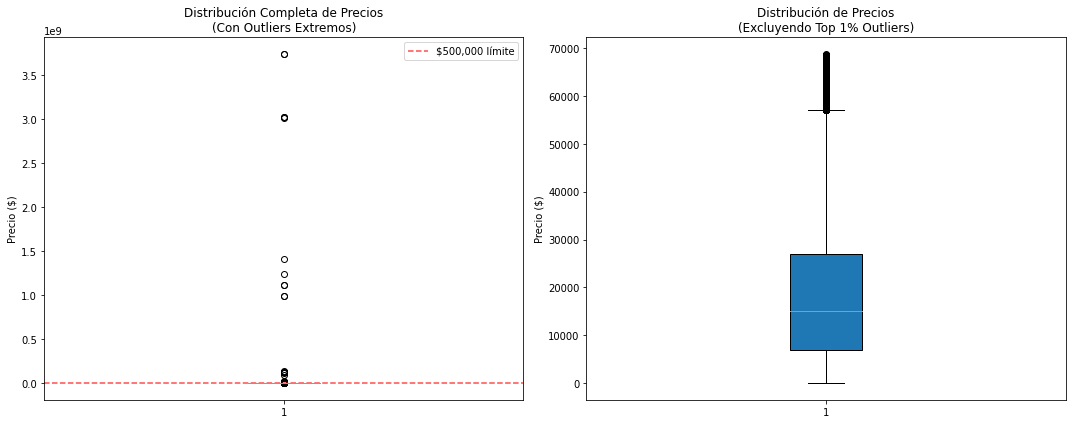

In [14]:
plt.figure(figsize=(15, 6))  # Figura más ancha para dos gráficos horizontales

# Gráfico 1: Distribución completa con outliers (IZQUIERDA)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
boxplot = plt.boxplot(df['price'].dropna(), vert=True, patch_artist=True)
plt.title('Distribución Completa de Precios\n(Con Outliers Extremos)')
plt.ylabel('Precio ($)')

# Identificar y marcar outliers extremos
outliers = boxplot['fliers'][0].get_ydata()
if len(outliers) > 0:
    outlier_500k = outliers[outliers > 500000]
    print(f"Outliers por encima de $500,000: {len(outlier_500k)}")
    
    plt.axhline(y=500000, color='red', linestyle='--', alpha=0.7, 
                label='$500,000 límite')
    plt.legend()

# Gráfico 2: Distribución sin outliers extremos (DERECHA)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
reasonable_data = df[df['price'] <= df['price'].quantile(0.99)]
plt.boxplot(reasonable_data['price'].dropna(), vert=True, patch_artist=True)
plt.title('Distribución de Precios\n(Excluyendo Top 1% Outliers)')
plt.ylabel('Precio ($)')

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

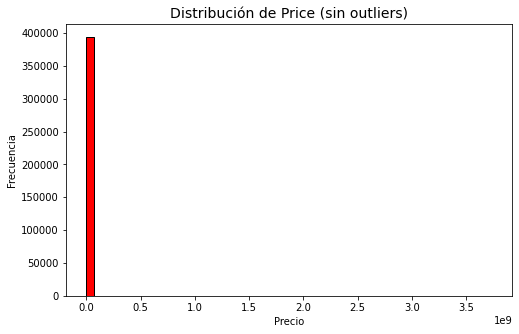

In [15]:
# Crear histograma
plt.figure(figsize=(8,5))
plt.hist(df["price"], bins=50, color='red', edgecolor="black")
plt.title("Distribución de Price (sin outliers)", fontsize=14)
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

En el caso de la variable **`price`**, que constituye la **variable objetivo a predecir**, es fundamental mantener un rango de valores lo más **realista y representativo posible del mercado**. Los registros con precios superiores a **500.000 dólares** no solo corresponden a valores atípicos poco plausibles, sino que además introducen **sesgos importantes en la distribución de la variable dependiente**.  

La presencia de estos outliers puede:  
1. **Distorsionar la media y la desviación estándar**, generando estadísticas descriptivas poco fiables.  
2. **Afectar la visualización de la distribución de precios**, como se observa en el histograma, donde los valores extremos comprimen la escala y ocultan la estructura de los datos reales.  
3. **Perjudicar el desempeño de los modelos predictivos**, ya que podría ajustar sus parámetros  para dar cabida a valores irreales, perdiendo capacidad de generalización frente a precios del mercado real.  
4. **Inducir errores en la interpretación de los resultados**, al hacer parecer que existen vehículos con precios extremadamente elevados, lo cual no corresponde con la realidad del dominio del problema.  

Por estas razones, se opta por **eliminar los registros con `price > 500000`**, garantizando que la variable predictora refleje de manera fidedigna el rango de precios de los vehículos y que los modelos entrenados a partir de ella produzcan predicciones coherentes y útiles.


##### **2.1.1.2. Corrección:**

Iniciamos haciendo una prueba de normalidad con el fin de ver o corroborar que nuestra variable no proviene de una distribución normal.

In [16]:
columna = "price"

# Extraemos la columna y quitamos valores NaN
data = df[columna].dropna()

# Estandarizamos (media=0, std=1) para compararla con la normal estándar
data_std = (data - data.mean()) / data.std(ddof=1)

# Prueba de Kolmogorov-Smirnov contra la normal estándar
stat, p_value = kstest(data_std, 'norm')

print("Prueba de Kolmogorov-Smirnov (K-S)")
print("Estadístico:", stat)
print("p-valor:", p_value)

if p_value < 0.05:
    print("Se rechaza la hipótesis de normalidad (no es normal).")
else:
    print("No se rechaza la hipótesis de normalidad (compatible con normal).")


Prueba de Kolmogorov-Smirnov (K-S)
Estadístico: 0.49779804749671464
p-valor: 0.0
Se rechaza la hipótesis de normalidad (no es normal).


Haciendo uso de la función de identificación de outliers —la cual utiliza los cuartiles—, se seleccionaron aquellos registros extremos que afectaban la interpretación de la variable price para, posteriormente, excluirlos del estudio.

In [17]:
outliers = identificar_outliers(df,'price',columns_to_show=['year', 'manufacturer', 'model','price','condition'])

          year   manufacturer  model         price          condition
318592  2007.0         toyota  Other  3.736929e+09          excellent
356716  1999.0         toyota  Other  3.736929e+09               fair
91576   2000.0  mercedes-benz  Other  3.024942e+09  condition_missing
257840  2000.0  mercedes-benz  Other  3.024942e+09  condition_missing
37410   2021.0      chevrolet  f-150  3.009549e+09  condition_missing
...        ...            ...    ...           ...                ...
2267    1933.0           ford  Other  5.850000e+04  condition_missing
347371  2020.0           ford  Other  5.850000e+04           like new
386187  2016.0            bmw  Other  5.850000e+04  condition_missing
229212  2020.0           jeep  Other  5.849900e+04           like new
101650  2019.0           ford  Other  5.849800e+04  condition_missing

[7779 rows x 5 columns]

Cantidad de outliers en price: 7779
Límites IQR: [-23885.00, 58475.00]
Rango de outliers: [58498.00, 3736928711.00]


Note que, con este método de los cuartiles para la variable precio, logramos encontrar 7779 outliers que, aunque en proporción no son relevantes, al ser muy extremos afectan la forma de nuestra distribución, impidiendo que podamos visualizarla adecuadamente.

In [18]:
outliers_mayores_200k = outliers[outliers['price'] > 500000]

# Calcular proporción
proporcion = len(outliers_mayores_200k) / len(outliers)

print(f"Cantidad total de outliers: {len(outliers)}")
print(f"Cantidad de outliers > 500000: {len(outliers_mayores_200k)}")
print(f"Proporción: {proporcion:.2%}")

# Eliminar las filas con price > 500000
df_sin_out = df[df["price"] <= 500000]

print(f"Nuevo tamaño del dataset: {df_sin_out.shape[0]} filas")

Cantidad total de outliers: 7779
Cantidad de outliers > 500000: 68
Proporción: 0.87%
Nuevo tamaño del dataset: 393917 filas


Con el método de cuartiles, se identificaron 7,779 valores atípicos en el precio, de los cuales solo 68 (0.87%) correspondían a valores extremos superiores a $500,000. Tras eliminar estos outliers, el dataset se redujo a 393,917 registros, conservando así más del 98% de los datos originales y obteniendo una distribución de precios más realista y analizable para el estudio.

In [19]:
df_sin_out['price'].describe()

count    393917.000000
mean      18901.892977
std       15398.143446
min           1.000000
25%        7000.000000
50%       15000.000000
75%       27590.000000
max      470000.000000
Name: price, dtype: float64

Tras la limpieza de outliers, la distribución de precios muestra una media de $18,902 con una mediana de $15,000, indicando una asimetría hacia valores más bajos. El 50% de los vehículos se concentra entre $7,000 y $27,590, con un rango realista que va desde $1 hasta $470,000, lo que refleja una distribución más coherente y analizable para el estudio del mercado de autos usados.

Ahora, es posible analizar de forma explicita la distribución de nuestra variable price. Tambien realizamos pruebas estadisticas con el fin de corroborar que la manipulación realizada no haya cambiado la distribución de nuestros datos.

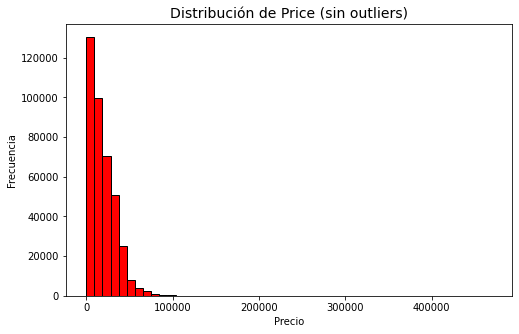

In [20]:
# Crear histograma
plt.figure(figsize=(8,5))
plt.hist(df_sin_out["price"], bins=50, color='red', edgecolor="black")
plt.title("Distribución de Price (sin outliers)", fontsize=14)
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

In [21]:
# Quitamos NaN en caso de que aún existan
antes = df["price"].dropna()
despues = df_sin_out["price"].dropna()

# Kolmogorov–Smirnov (para comparar distribuciones completas)
stat3, p3 = ks_2samp(antes, despues)
print("K-S Test:", stat3, " p-valor:", p3)

K-S Test: 0.00017259540337832835  p-valor: 1.0


Con un nivel de significancia de 0.05 y un p-valor de 1, al ser este mayor que el valor de α, no se rechaza la hipótesis nula. Por lo tanto, se concluye que no existen diferencias estadísticamente significativas en la distribución de price antes y después de la manipulación.

Dado que logramos comprobar que los cambios realizados no afectaron la distribución de los datos, asignamos los cambios a nuestro dataframe original.

In [22]:
df=df_sin_out

#### **2.1.2 Manipulación de `odometer`**

In [23]:
df['odometer'].describe()

count    3.939170e+05
mean     9.861456e+04
std      2.047012e+05
min      0.000000e+00
25%      3.824800e+04
50%      8.640000e+04
75%      1.350000e+05
max      1.000000e+07
Name: odometer, dtype: float64

La variable **`odometer`** (kilometraje) cuenta con **393.917 observaciones válidas**. El valor promedio del odómetro es de aproximadamente **98.615 km**, lo que refleja un kilometraje medio esperado en vehículos usados. La mediana es de **86.400 km**, lo que indica que la mayoría de los vehículos se concentran por debajo de los 100.000 km. El 50% de los registros se encuentra entre **38.248 km** y **135.000 km**, un rango que puede considerarse representativo para automóviles en condiciones normales de uso.  

El mínimo registrado es de **0 km**, lo que puede corresponder a vehículos nuevos o a registros erróneos, mientras que el máximo alcanza los **10.000.000 km**, un valor inverosímil que constituye un **outlier** y probablemente se deba a un error de registro. La desviación estándar es de aproximadamente **204.701 km**, lo cual evidencia una gran dispersión en los datos, reforzada por la existencia de valores extremos.  

En conclusión, aunque los datos centrales muestran un kilometraje coherente con el uso real de vehículos (principalmente entre **38.000 y 135.000 km**), la presencia de registros con valores extremos como **0 km** y **10.000.000 km** sugiere la existencia de **outliers** que podrían distorsionar el análisis si no se tratan adecuadamente.

##### **2.1.2.1. Análisis:**

In [24]:
# Estandarizamos (media=0, std=1) para compararla con la normal estándar
data_std = (df['odometer'] - df['odometer'].mean()) / df['odometer'].std(ddof=1)

# Prueba de Kolmogorov-Smirnov contra la normal estándar
stat, p_value = kstest(data_std, 'norm')

print("Prueba de Kolmogorov-Smirnov (K-S)")
print("Estadístico:", stat)
print("p-valor:", p_value)

if p_value < 0.05:
    print("Se rechaza la hipótesis de normalidad (no es normal).")
else:
    print("No se rechaza la hipótesis de normalidad (compatible con normal).")


Prueba de Kolmogorov-Smirnov (K-S)
Estadístico: 0.3149922134042815
p-valor: 0.0
Se rechaza la hipótesis de normalidad (no es normal).


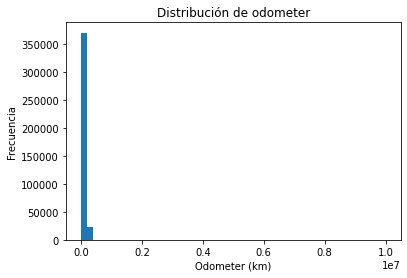

Máximo reportado: 10000000.0


In [25]:
plt.hist(df["odometer"], bins=50)
plt.xlabel("Odometer (km)")
plt.ylabel("Frecuencia")
plt.title("Distribución de odometer")
plt.show()

print("Máximo reportado:", df["odometer"].max())

El histograma muestra una distribución altamente sesgada a la derecha, donde la gran mayoría de los vehículos tiene kilometrajes bajos (concentrados entre 0-200,000 km), mientras que existe una cantidad mínima de registros con valores extremadamente altos (hasta 10,000,000 km). Este patrón sugiere la presencia de outliers absurdos que distorsionan la escala, probablemente debido a errores de registro donde se ingresaron valores erróneos. La concentración principal en valores bajos refleja el comportamiento esperado del mercado de autos usados, donde la mayoría de los vehículos tienen kilometrajes realistas.

Outliers por encima de 600,000 km: 1101


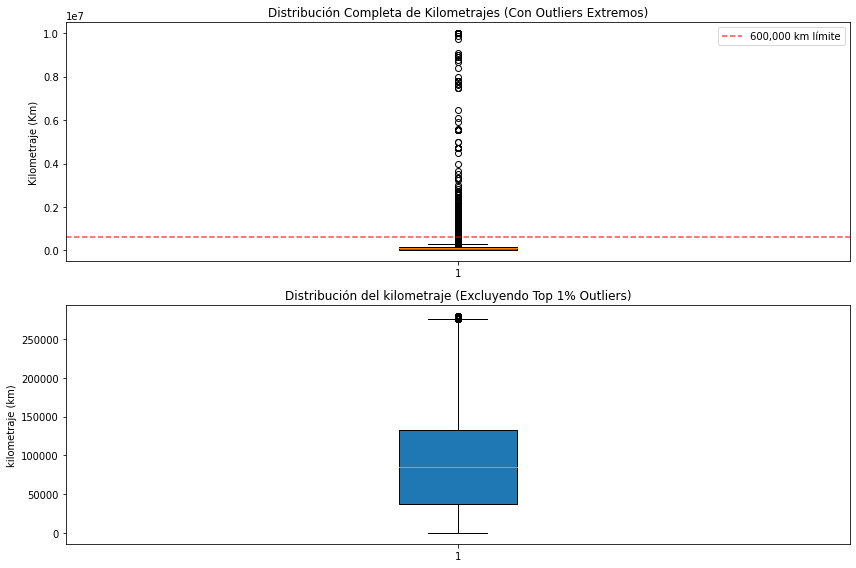

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
boxplot = plt.boxplot(df['odometer'].dropna(), vert=True, patch_artist=True)
plt.title('Distribución Completa de Kilometrajes (Con Outliers Extremos)')
plt.ylabel('Kilometraje (Km)')


outliers = boxplot['fliers'][0].get_ydata()
if len(outliers) > 0:
    outlier_600k = outliers[outliers > 600000]
    print(f"Outliers por encima de 600,000 km: {len(outlier_600k)}")
    
    plt.axhline(y=600000, color='red', linestyle='--', alpha=0.7, 
                label='600,000 km límite')
    plt.legend()

plt.subplot(2, 1, 2)
reasonable_data = df[df['odometer'] <= df['odometer'].quantile(0.99)]
plt.boxplot(reasonable_data['odometer'].dropna(), vert=True, patch_artist=True)
plt.title('Distribución del kilometraje (Excluyendo Top 1% Outliers)')
plt.ylabel('kilometraje (km)')

plt.tight_layout()
plt.show()

El gráfico muestra dos distribuciones contrastantes. En la parte superior, con outliers incluidos, se observan valores absurdamente altos (hasta ~250,000 km en el boxplot pero con datos hasta 10,000,000 km en el histograma anterior), confirmando la presencia de errores extremos en el registro de kilometraje. La línea roja en 600,000 km marca un límite razonable para valores plausibles.

En la parte inferior, al excluir el top 1% de outliers, emerge la distribución real: la mayoría de los vehículos tiene entre ~50,000 km y ~150,000 km, con una mediana alrededor de ~100,000 km. Este patrón refleja el comportamiento esperado del mercado de autos usados, donde el kilometraje se concentra en rangos creíbles y analizables, permitiendo estudiar adecuadamente la relación entre kilometraje y precio.

##### **2.1.2.2. Corrección:**

In [27]:
outliers_odometer=identificar_outliers(df,'odometer')

                    region    price    year manufacturer  model  \
108797  sarasota-bradenton    450.0  2000.0         ford  f-150   
109840  sarasota-bradenton    450.0  2000.0         ford  f-150   
110253  sarasota-bradenton    450.0  2000.0         ford  f-150   
23100          bakersfield  15000.0  1957.0    chevrolet  Other   
320410     medford-ashland      1.0  1950.0        dodge  Other   
...                    ...      ...     ...          ...    ...   
175314   central louisiana  24995.0  2011.0          gmc  Other   
389570     charlottesville   1700.0  2003.0      hyundai  Other   
5847    anchorage / mat-su   1000.0  2002.0         ford  Other   
156694          des moines   8999.0  2012.0    chevrolet  Other   
230574           asheville   6500.0  2006.0    chevrolet  Other   

                condition  cylinders    fuel    odometer title_status  \
108797  condition_missing          6     gas  10000000.0        clean   
109840  condition_missing          6     gas  100

Se utilizó la función de identificación de outliers para aplicar el mismo proceso de detección y eliminación sobre la variable odometer, tomando como referencia el rango previamente planteado. De esta forma, se filtraron los valores extremos que distorsionaban la distribución del kilometraje y se garantizó que los datos restantes reflejaran de manera más representativa el comportamiento real de los vehículos.

In [28]:
outliers_mayores_200k = outliers_odometer[outliers_odometer['odometer'] > 00000]

# Calcular proporción
proporcion = len(outliers_mayores_200k) / len(outliers_odometer)

print(f"Cantidad total de outliers: {len(outliers_odometer)}")
print(f"Cantidad de outliers > 600000: {len(outliers_mayores_200k)}")
print(f"Proporción: {proporcion:.2%}")

df_sin_out = df[df['odometer']<=600000]
print(f"Nuevo tamaño del dataset: {df_sin_out.shape[0]} filas")

Cantidad total de outliers: 3916
Cantidad de outliers > 600000: 3916
Proporción: 100.00%
Nuevo tamaño del dataset: 392816 filas


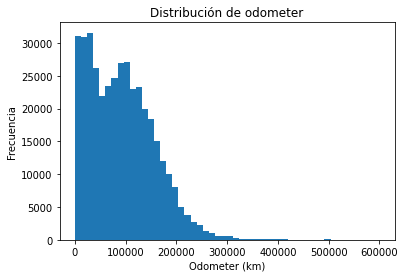

Máximo reportado: 600000.0


In [29]:
plt.hist(df_sin_out["odometer"], bins=50)
plt.xlabel("Odometer (km)")
plt.ylabel("Frecuencia")
plt.title("Distribución de odometer")
plt.show()

print("Máximo reportado:", df_sin_out["odometer"].max())

In [30]:
# Kolmogorov–Smirnov (para comparar distribuciones completas)
stat3, p3 = ks_2samp(df["odometer"], df_sin_out["odometer"])
print("K-S Test:", stat3, " p-valor:", p3)

K-S Test: 0.0027950050391326586  p-valor: 0.09238296175040916


con p-valor > 0.05 se rechaza la hipotesis nula y se concluye que no hay diferencias estadisticamente significativas entre las distribuciones antes y despues de la manipulación.

In [31]:
df = df_sin_out

Dado que logramos comprobar que los cambios realizados no afectaron la distribución de los datos, asignamos los cambios a nuestro dataframe original.

### **2.2 Análisis outliers numéricas:**

#### **2.2.1. `Odometer`:**

Al aplicar la función de identificación de outliers sobre la variable `odometer`, se eliminaron los valores extremos que no representaban el comportamiento típico del kilometraje de los vehículos.  
Estos registros atípicos podían distorsionar la distribución y generar conclusiones poco fiables.  

Tras la depuración, los datos restantes ofrecen una representación más clara y realista del uso habitual de los vehículos, lo que mejora la calidad del análisis estadístico y permite realizar comparaciones más precisas.


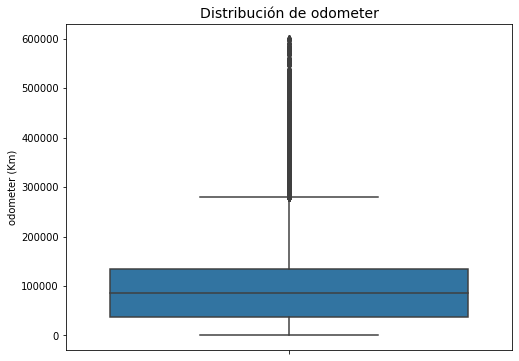

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="odometer")
plt.title("Distribución de odometer", fontsize=14)
plt.ylabel("odometer (Km)")
plt.show()

La distribución del odómetro muestra una concentración masiva de vehículos en rangos bajos y moderados (0-200,000 km), con una larga cola hacia valores extremos que alcanzan hasta 600,000 km, lo que indica la presencia de outliers probablemente erróneos que distorsionan la visualización y requieren filtrarse para un análisis representativo del mercado real de autos usados.

In [33]:
outliers_odometer=identificar_outliers(df,'odometer',columns_to_show= ['year','model','odometer','price'])

          year  model  odometer    price
407566  1991.0  Other  600000.0      1.0
11423   2005.0  Other  600000.0  40000.0
100909  2011.0  Other  600000.0  13000.0
378358  2013.0  Other  600000.0  16500.0
372388  2012.0  Other  600000.0  14900.0
...        ...    ...       ...      ...
45975   1999.0  Other  279746.0   3000.0
51907   1999.0  Other  279746.0   3000.0
202331  2011.0  Other  279715.0  23994.0
396324  2012.0  Other  279700.0   5500.0
380660  2010.0  Other  279681.0  20999.0

[2922 rows x 4 columns]

Cantidad de outliers en odometer: 2922
Límites IQR: [-106861.38, 279603.62]
Rango de outliers: [279681.00, 600000.00]


El análisis identificó 2,922 outliers de odómetro y se revelaron dos tipos distintos de outliers: vehículos con alto kilometraje realista (279,681-400,000 km) que podrían corresponder a unidades de trabajo legítimas, y valores que podrian ser resultado de una mala tabulación como los múltiples registros con exactamente 600,000 km acompañados de precios poco realistas ($1), que deben eliminarse completamente del dataset para no distorsionar los análisis.

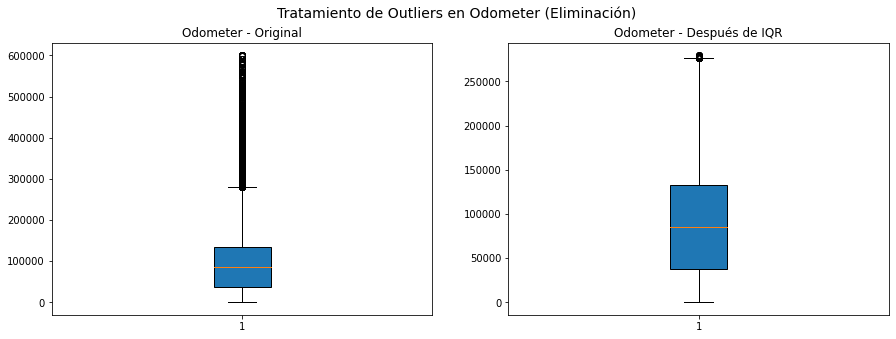

In [34]:
odometer = df["odometer"].dropna()

#Tratamiento por IQR 
Q1 = odometer.quantile(0.25)
Q3 = odometer.quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Filtrar todo el DataFrame eliminando outliers
df_filtrado = df[(df["odometer"] >= limite_inf) & (df["odometer"] <= limite_sup)]

# --- Boxplots comparativos ---
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].boxplot(odometer, vert=True, patch_artist=True)
axes[0].set_title("Odometer - Original")

axes[1].boxplot(df_filtrado['odometer'], vert=True, patch_artist=True)
axes[1].set_title("Odometer - Después de IQR")

plt.suptitle("Tratamiento de Outliers en Odometer (Eliminación)", fontsize=14)
plt.show()



Al aplicar la función de identificación de outliers sobre la variable *odometer*, se eliminaron los valores extremos que distorsionaban la distribución del kilometraje.  

Esto permitió que los datos conservaran únicamente observaciones más representativas del comportamiento real de los vehículos.  

En consecuencia, el análisis posterior se basará en un conjunto de datos más limpio y confiable, reduciendo el sesgo que podrían generar registros atípicos poco frecuentes.


In [35]:
df = df_filtrado

#### **2.2.2. `Año`:**

In [36]:
df['year'].describe()

count    389894.000000
mean       2011.114739
std           9.504920
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2022.000000
Name: year, dtype: float64

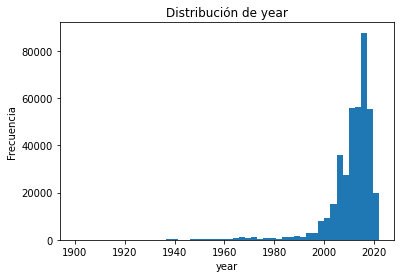

In [37]:
plt.hist(df["year"], bins=50)
plt.xlabel("year")
plt.ylabel("Frecuencia")
plt.title("Distribución de year")
plt.show()

La distribución del año de fabricación muestra una concentración masiva de vehículos entre 2000 y 2020, con muy pocos registros anteriores a 1980, lo que refleja el comportamiento esperado del mercado de autos usados donde predominan vehículos recientes. Sin embargo, la presencia de registros en 1900 resulta estadísticamente improbable y sugiere errores de digitación o valores por defecto, ya que sería excepcional encontrar vehículos con más de 120 años en el mercado convencional.

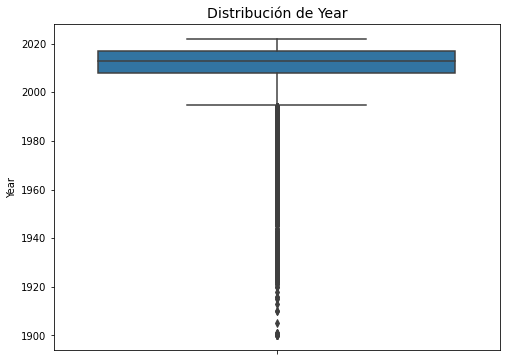

In [38]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="year")
plt.title("Distribución de Year", fontsize=14)
plt.ylabel("Year")
plt.show()

La distribución muestra vehículos desde 1900 hasta 2020, pero presenta una concentración masiva en años recientes (2000-2020), con una cola larga hacia años más antiguos. La presencia de vehículos de 1900-1940 es sospechosa y probablemente corresponde a errores de registro o valores por defecto, ya que es extremadamente raro encontrar vehículos tan antiguos en el mercado convencional de autos usados. El pico en años recientes refleja el comportamiento esperado del mercado, donde la mayoría de los vehículos disponibles tienen menos de 20 años.

In [39]:
outliers_year=identificar_outliers(df,'year',columns_to_show=['year','manufacturer','model','condition'])

          year manufacturer  model          condition
363495  1994.0     cadillac  Other               good
153547  1994.0    chevrolet  Other  condition_missing
80254   1994.0         jeep  Other  condition_missing
401279  1994.0        honda  Other               fair
153072  1994.0    chevrolet  Other          excellent
...        ...          ...    ...                ...
95914   1900.0         ford  Other  condition_missing
154138  1900.0         ford  Other  condition_missing
44754   1900.0         ford  Other               good
269472  1900.0         ford  Other  condition_missing
123023  1900.0         ford  Other          excellent

[14994 rows x 4 columns]

Cantidad de outliers en year: 14994
Límites IQR: [1994.50, 2030.50]
Rango de outliers: [1900.00, 1994.00]


Los outliers de año revelan dos problemas distintos: errores, como registros de 1900 con modelos inexistentes, que deben eliminarse completamente, y vehículos legítimos pero antiguos (1994 o anteriores) que, aunque válidos, son atípicos en el mercado actual y podrían distorsionar los modelos predictivos. Por lo tanto, en este caso, hemos decidido filtrar el año tomando registros dentro de un rango más realista.

In [40]:
df_limpio, outliers_year = limpiar_outliers_year(df, columna="year", minimo=1950)

 Valores fuera de rango detectados:
1900.0    11
1901.0     3
1905.0     1
1910.0     2
1913.0     1
1915.0     1
1916.0     2
1918.0     1
1920.0     2
1921.0     2
1922.0     2
1923.0    36
1924.0     9
1925.0     8
1926.0    16
1927.0    34
1928.0    35
1929.0    52
1930.0    67
1931.0    56
1932.0    53
1933.0    24
1934.0    42
1935.0    23
1936.0    41
1937.0    69
1938.0    36
1939.0    44
1940.0    77
1941.0    63
1942.0    13
1943.0     1
1944.0     3
1945.0     1
1946.0    56
1947.0    62
1948.0    94
1949.0    74
Name: year, dtype: int64
Total de registros fuera de rango: 1117

Dataset limpio: 388777 filas (de 389894 originales)


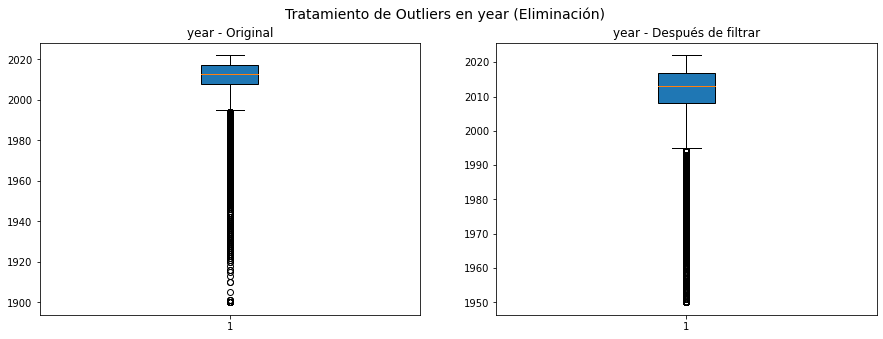

In [41]:
# --- Boxplots comparativos ---
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].boxplot(df['year'], vert=True, patch_artist=True)
axes[0].set_title("year - Original")

axes[1].boxplot(df_limpio['year'], vert=True, patch_artist=True)
axes[1].set_title("year - Después de filtrar")

plt.suptitle("Tratamiento de Outliers en year (Eliminación)", fontsize=14)
plt.show()

 En el panel izquierdo (original), se podemos observar muchos valores atípicos hacia años muy antiguos (incluso cercanos a 1900), que distorsionan la representación y hacen menos clara la concentración de datos. En el panel derecho (después de filtrar), estos valores extremos han sido eliminados, lo que genera una distribución más compacta y representativa: la mayoría de los registros se concentran entre 2000 y 2020, con una mediana alrededor de 2010-2012. Esto permite un análisis más preciso al centrarse en los vehículos modernos y reducir el efecto de observaciones poco frecuentes o inconsistentes.

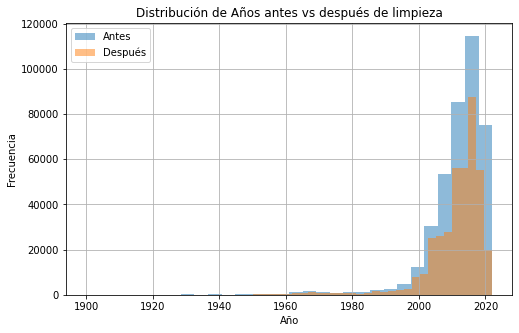

Kolmogorov-Smirnov test
Estadístico: 0.0028648812241275834   p-valor: 0.08173203191704215


In [42]:
antes = df["year"]
despues = df_limpio["year"]


plt.figure(figsize=(8,5))
antes.hist(bins=30, alpha=0.5, label="Antes")
despues.hist(bins=30, alpha=0.5, label="Después")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.title("Distribución de Años antes vs después de limpieza")
plt.legend()
plt.show()


stat, p_value = ks_2samp(antes, despues)
print("Kolmogorov-Smirnov test")
print("Estadístico:", stat, "  p-valor:", p_value)

Se observa que antes de la limpieza (en azul) existían registros dispersos en años muy antiguos, incluso desde 1900, lo que generaba valores poco frecuentes y posiblemente erróneos. Después de la limpieza (en naranja), estos valores atípicos fueron eliminados y la distribución se concentra de forma clara a partir del año 2000, con un fuerte pico entre 2010 y 2020, que es donde se encuentran la mayoría de los vehículos. Esto evidencia que la limpieza permitió depurar datos poco representativos y resaltar la verdadera tendencia: la base de datos está compuesta principalmente por vehículos modernos de las últimas dos décadas.

Con un nivel de significancia de 0.05 y un p-valor de 0.0817, no se rechaza la hipótesis nula, por lo que no hay evidencia estadísticamente significativa para afirmar que existen diferencias entre las distribuciones antes y después del tratamiento.


In [43]:
df = df_limpio

#### **2.2.3. `lat` & `long`:** 

Dado que la latitud (`lat`) y la longitud (`long`) son variables georreferenciadas, no pueden imputarse de la misma forma que las demás variables; por lo tanto, en este caso recurrimos a hacerlo en función de la región.

In [44]:
# Calcular la mediana de lat y long por region
region_coords = df.groupby("region")[["lat", "long"]].median()

# Función para corregir coordenadas incoherentes
def corregir_coordenadas(row):
    # Si las coordenadas están fuera del rango de EEUU, reemplazar
    if not (25 <= row["lat"] <= 49 and -125 <= row["long"] <= -67):
        return pd.Series(region_coords.loc[row["region"]])
    else:
        return pd.Series({"lat": row["lat"], "long": row["long"]})

# Aplicar corrección
df[["lat", "long"]] = df.apply(corregir_coordenadas, axis=1)


c:\Users\Janus\miniconda3\envs\ml_venv\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


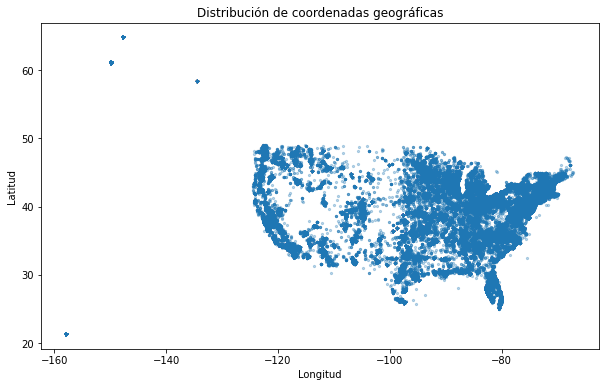

In [45]:
# Scatter plot simple de lat y long
plt.figure(figsize=(10,6))
plt.scatter(df["long"], df["lat"], alpha=0.3, s=5)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Distribución de coordenadas geográficas")
plt.show()

Se observa que la gran mayoría de los puntos se concentran dentro del territorio continental de Estados Unidos, lo que indica que los datos están georreferenciados principalmente en esa región. También aparecen algunos puntos aislados fuera del área principal, hacia el oeste (alrededor de Alaska y posiblemente Hawái), los cuales podrían considerarse valores esperados si incluyen esos territorios. En conjunto, la visualización confirma que la base de datos refleja ubicaciones reales y mayoritariamente coherentes dentro de EE. UU.

### **2.3. Análisis variables numéricas:**

In [46]:
col_num = ['price', 'year', 'cylinders', 'odometer']

df[col_num].describe()

,price,year,cylinders,odometer
count,388777.000000,388777.000000,388777.000000,388777.000000
mean,18957.696983,2011.328692,5.913562,90793.299326
std,15368.687664,8.625278,1.587319,60728.202336
min,1.000000,1950.000000,3.000000,0.000000
25%,7295.000000,2008.000000,4.000000,38000.000000
50%,15495.000000,2013.000000,6.000000,85548.000000
75%,27831.000000,2017.000000,8.000000,133413.000000
max,470000.000000,2022.000000,12.000000,279570.000000


**Price (precio):** El promedio es de 18,958 USD, la mediana es 15,495 USD, con un 50% de autos entre 7,295 y 27,831 USD. Adicionalmente, existen valores extremos de hasta 470,000 USD.

**Year (año):** La media es de 2011.32, el mínimo es 1950 y la mayoría de los autos se concentran entre 2008 y 2017.

**Cylinders (cilindros):** El promedio es de casi 6 cilindros, con una distribución centrada en valores comunes de 4, 6 y 8 cilindros, que son los más representativos en automóviles y camionetas. El mínimo es 3 y el máximo 12, coherente con motores pequeños y grandes.

**Odometer (kilometraje):** El kilometraje medio es ~90,793 millas, con un rango intercuartílico entre 38,000 y 133,413 millas, lo que refleja la distribución típica de autos usados. Aún se mantienen registros extremos (0 y más de 270,000 millas), pero representan casos poco frecuentes.

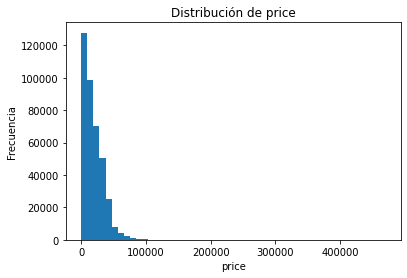

In [47]:
plt.hist(df["price"], bins=50)
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.title("Distribución de price")
plt.show()

Se observa que la distribución está fuertemente sesgada a la derecha. La gran mayoría de los vehículos se concentran en precios bajos, principalmente por debajo de 50,000 USD, con un pico muy marcado en el rango de 0 a 20,000 USD, lo cual coincide con autos usados más comunes en el mercado. A medida que el precio aumenta, la frecuencia disminuye rápidamente, pero aún existen algunos valores extremos muy altos (superiores a 100,000 USD e incluso cercanos a 400,000–470,000 USD) que actúan como outliers y distorsionan la escala del gráfico. Esto indica que, aunque la mayoría de los datos corresponden a precios razonables, los valores atípicos influyen en la forma de la distribución.

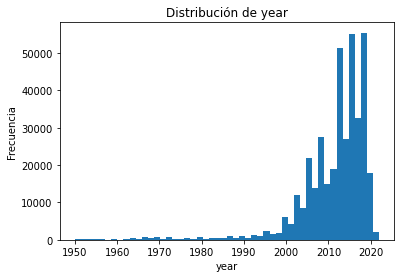

In [48]:
plt.hist(df["year"], bins=50)
plt.xlabel("year")
plt.ylabel("Frecuencia")
plt.title("Distribución de year")
plt.show()

Se observa que la mayor concentración de vehículos corresponde a modelos fabricados entre el año 2000 y 2022, con un notable incremento en la frecuencia a partir del 2010. Los años anteriores a 1990 aparecen con frecuencias muy bajas, lo que indica que son casos aislados de autos antiguos, mientras que los modelos más recientes dominan claramente el conjunto de datos. Esto refleja que el mercado analizado está compuesto principalmente por vehículos relativamente nuevos, lo que resulta consistente con la dinámica de compraventa actual.

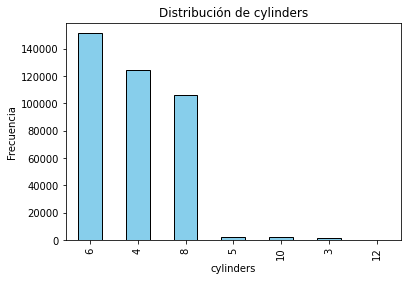

In [49]:
conteo = df["cylinders"].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
conteo.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribución de cylinders")
plt.xlabel("cylinders")
plt.ylabel("Frecuencia")
plt.show()

 Se observa que la mayoría de los autos tienen 6 cilindros, seguidos por los de 4 cilindros y luego los de 8 cilindros, lo cual coincide con los motores más comunes en el mercado (vehículos estándar, compactos y camionetas/SUV). Los vehículos con configuraciones menos comunes, como 3, 5, 10 o 12 cilindros, aparecen con una frecuencia muy baja, representando casos aislados.

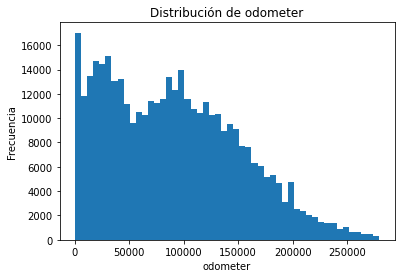

In [50]:
plt.hist(df["odometer"], bins=50)
plt.xlabel("odometer")
plt.ylabel("Frecuencia")
plt.title("Distribución de odometer")
plt.show()

muestra que la mayoría de los vehículos tienen un kilometraje relativamente bajo a moderado (entre 0 y 100,000), con un pico muy alto en valores cercanos a 0 que puede corresponder tanto a autos nuevos como a registros anómalos. A medida que aumenta el kilometraje, la frecuencia de vehículos disminuye de forma gradual, aunque aún se observan algunos con recorridos muy elevados (más de 200,000), lo que refleja que son casos menos comunes. En general, la distribución es asimétrica hacia la derecha, concentrada en valores bajos y con una larga cola hacia los kilometrajes más altos, lo cual es coherente con un mercado de autos donde predominan los vehículos poco usados frente a los de alto desgaste.

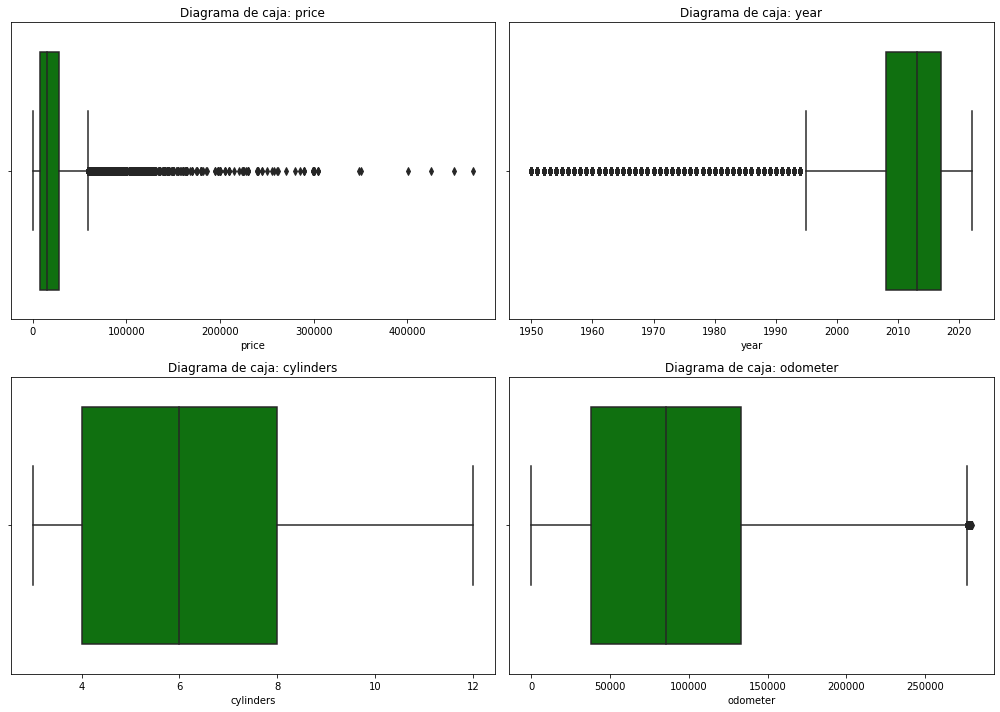

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Boxplots horizontales
for i, col in enumerate(col_num):
    sns.boxplot(x=df[col], ax=axs[i], color='green')
    axs[i].set_title(f'Diagrama de caja: {col}', fontsize=12)
    axs[i].set_xlabel(col)

plt.tight_layout()
plt.show()

Los diagramas de caja muestran la presencia de valores atípicos en todas las variables, aunque con diferente intensidad. En price, la mayoría de los autos se concentran en precios bajos, pero existe una gran cantidad de outliers hacia valores muy altos, lo que indica distorsión por autos de lujo o registros anómalos. En year, la mayoría de los vehículos son relativamente modernos (posteriores a 2000), mientras que los autos antiguos aparecen como outliers. En cylinders, la mayor parte se concentra entre 4, 6 y 8 cilindros, aunque hay valores extremos menos frecuentes como 3, 10 o 12. Finalmente, en odometer, se observa que la mayoría de los vehículos tienen un kilometraje medio (cerca de 100,000), pero hay algunos outliers con recorridos muy elevados.

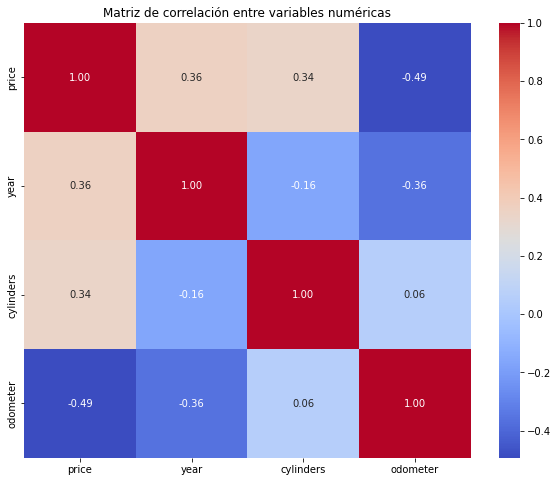

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[col_num].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

La matriz de correlación revela que el precio tiene una relación moderadamente fuerte con el kilometraje (correlación de -0.49), indicando que los vehículos con mayor kilometraje tienden a tener precios más bajos, y una relación positiva con el año (0.36) y los cilindros (0.34), mostrando que los autos más nuevos y con más cilindros suelen ser más costosos. Además, se observa una correlación negativa coherente entre el año y el kilometraje (-0.36), donde los vehículos más nuevos generalmente tienen menos kilometraje, mientras que las demás relaciones son débiles o irrelevantes, confirmando que no existe multicolinealidad significativa entre las variables predictoras.

## **3.EDA categóricas:**

Para iniciar este análisis de las variables categoricas iniciamos creando nuestra variable respuesta `high_demand` la cual usaremos para modelar.

In [53]:
df['high_demand'] = (df['price'] > df['price'].median()).astype(int)

C:\Users\Janus\AppData\Local\Temp/ipykernel_12720/2540990982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_demand'] = (df['price'] > df['price'].median()).astype(int)


In [54]:
cat_cols = ['manufacturer', 'model', 'condition', 'fuel', 'title_status','transmission', 'drive', 'type', 'paint_color', 'state', 'high_demand']

In [55]:
# Crear lista con la info resumen de las variables categóricas
summary = []

for col in cat_cols:
    total = len(df)
    n_missing = df[col].isna().sum()
    n_unique = df[col].nunique(dropna=True)
    top = df[col].value_counts(dropna=True).idxmax()
    freq = df[col].value_counts(dropna=True).max()
    top_pct = (freq / total) * 100

    summary.append({
        'Variable': col,
        'Categorías únicas': n_unique,
        'Valor más frecuente': top,
        'Frecuencia': freq,
        '% del más frecuente': round(top_pct, 2),
        'Nulos': n_missing
    })

# Convertir a DataFrame para visualizar como tabla
summary_df = pd.DataFrame(summary)

# Ordenar si deseas
summary_df = summary_df.sort_values(by='Categorías únicas', ascending=False)

# Mostrar como tabla
summary_df.style.set_caption("Resumen de variables categóricas")

,Variable,Categorías únicas,Valor más frecuente,Frecuencia,% del más frecuente,Nulos
9,state,33,ca,44730,11.510000,0
0,manufacturer,24,ford,78523,20.200000,0
7,type,13,type_missing,83673,21.520000,0
8,paint_color,11,paint_missing,115132,29.610000,0
2,condition,6,condition_missing,149640,38.490000,0
3,fuel,5,gas,329643,84.790000,0
6,drive,4,4wd,119518,30.740000,0
1,model,3,Other,372900,95.920000,0
4,title_status,3,clean,375726,96.640000,0
5,transmission,3,automatic,305199,78.500000,0


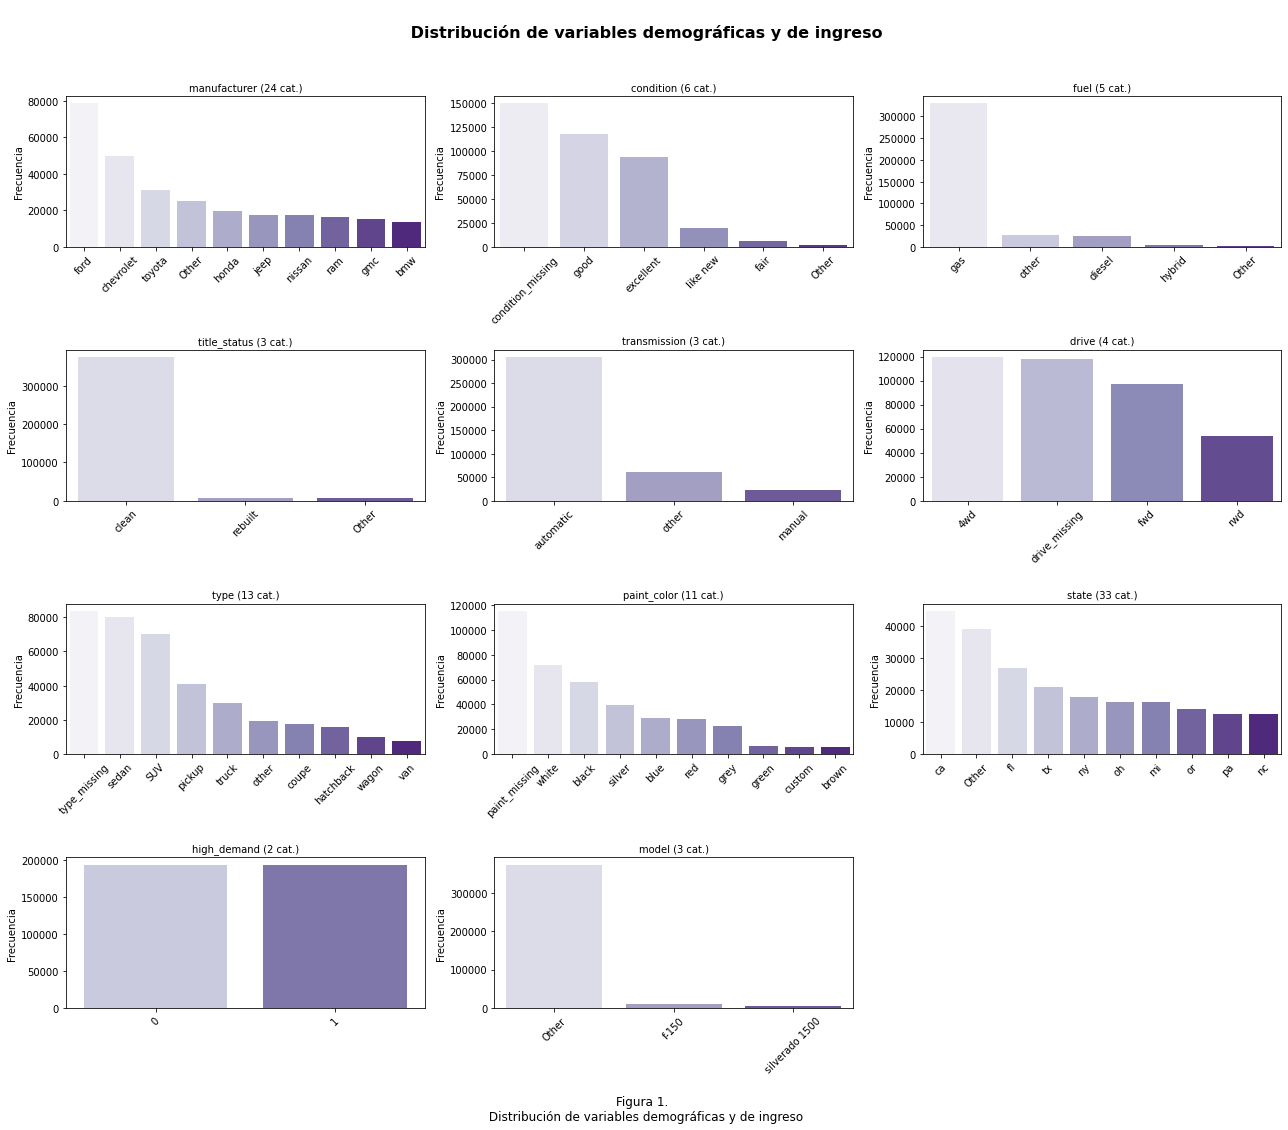

In [58]:
import math

cat_cols = ['manufacturer','condition', 'fuel', 'title_status','transmission', 'drive', 'type', 'paint_color', 'state', 'high_demand', 'model']
graficar_cat(len(cat_cols), cat_cols, figura_num=1,
             titulo_general='\n Distribución de variables demográficas y de ingreso',
             palette='Purples')

El conjunto de gráficos muestra cómo distintas variables categóricas —como fabricante, condición, tipo de combustible, estado legal del título, transmisión, tipo de tracción, tipo de vehículo, color de pintura, estado geográfico y demanda— se distribuyen en relación con el ingreso. De forma general, se observa que algunas categorías dentro de cada variable están asociadas a niveles de ingreso más altos, lo cual se refleja en los tonos más oscuros de las barras. Por ejemplo, ciertos fabricantes, tipos de transmisión o estados específicos parecen concentrar vehículos de mayor valor.

## ***4. Análsiis multivariado***

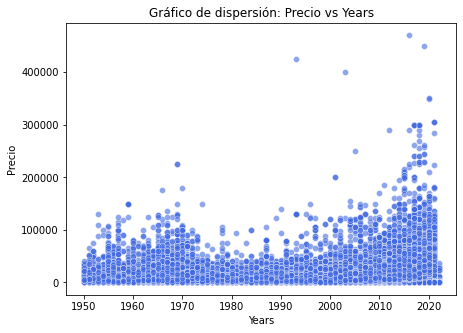

In [59]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="year", y="price", alpha=0.6, color="royalblue")

plt.title("Gráfico de dispersión: Precio vs Years")
plt.xlabel("Years")
plt.ylabel("Precio")

plt.show()


La gráfica muestra una dispersión de puntos que relaciona el precio de los autos con su año de fabricación. Se puede observar que, en general, los autos más recientes tienden a tener precios más altos. A partir del año 2000 en adelante, la densidad y altura de los puntos aumenta, lo que indica una tendencia creciente en los precios. También se notan varios valores atípicos, especialmente en los años más recientes, donde algunos vehículos alcanzan precios muy elevados. 

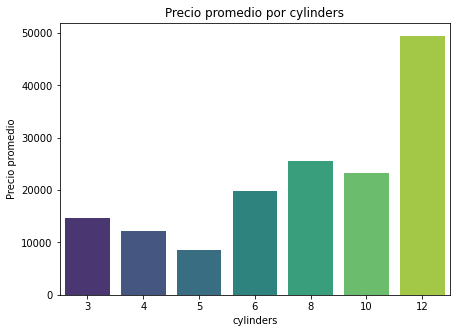

In [61]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="cylinders", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por cylinders")
plt.xlabel("cylinders")
plt.ylabel("Precio promedio")

plt.show()

El gráfico de barras muestra el precio promedio de los autos según la cantidad de cilindros. Se observa una relación directa: a mayor número de cilindros, mayor es el precio promedio del vehículo. Los autos con 12 cilindros presentan el valor promedio más alto, superando los 50,000, mientras que los de 5 cilindros tienen el valor más bajo. Esto indica que los motores más potentes suelen estar asociados a vehículos de gama alta o deportivos, lo cual eleva su precio significativamente.

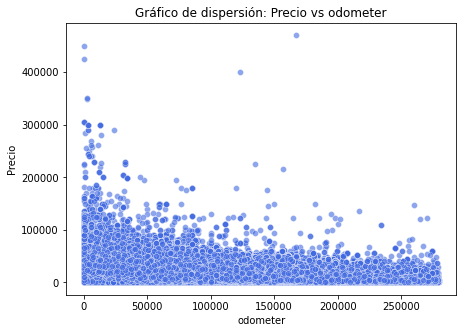

In [62]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="odometer", y="price", alpha=0.6, color="royalblue")

plt.title("Gráfico de dispersión: Precio vs odometer")
plt.xlabel("odometer")
plt.ylabel("Precio")

plt.show()

En este gráfico de dispersión se analiza la relación entre el precio de los autos y el kilometraje registrado en el odómetro. Se puede ver una clara tendencia decreciente: a medida que el kilometraje aumenta, el precio tiende a disminuir. Esto es esperable, ya que un mayor uso del vehículo suele implicar mayor desgaste y menor valor en el mercado. Sin embargo, hay varios puntos atípicos con precios muy altos incluso con bajo kilometraje, lo cual podría deberse a autos de lujo. En general, la gráfica confirma que el uso del vehículo es un factor importante que impacta negativamente en su precio.


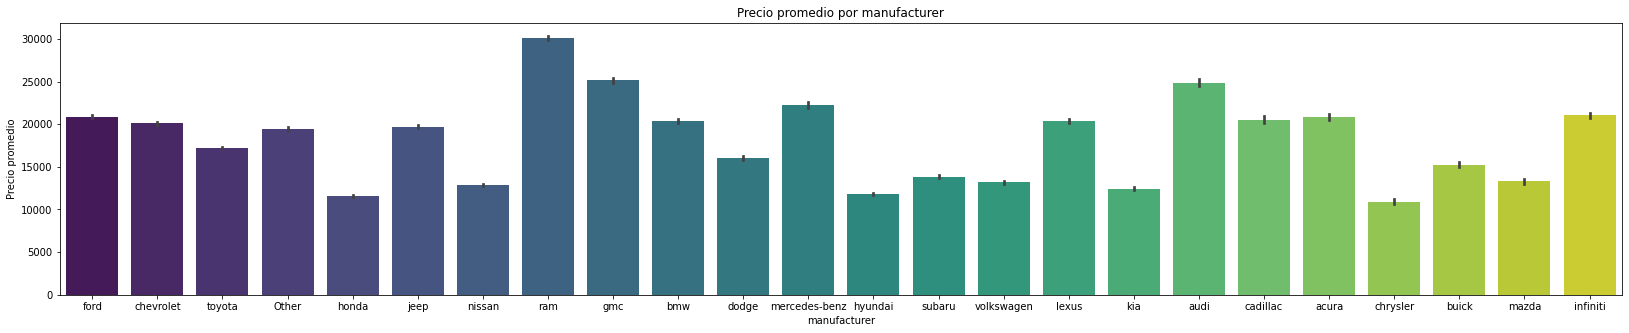

In [63]:
order = df['manufacturer'].value_counts().index  

plt.figure(figsize=(28,5))
sns.barplot(data=df, x="manufacturer", y="price", order=order, palette="viridis")

plt.title("Precio promedio por manufacturer")
plt.xlabel("manufacturer")
plt.ylabel("Precio promedio")

plt.show()

El gráfico de barras muestra el precio promedio de vehículos según su fabricante. Se observa que marcas de lujo como BMW, Audi, Cadillac y Mercedes-Benz tienen los precios promedio más altos, lo cual es consistente con su posicionamiento en el mercado. En contraste, fabricantes como Nissan, Kia y Hyundai presentan precios promedio más bajos, lo que sugiere que están orientados a un público más general o con menor poder adquisitivo. Esto evidencia cómo la marca influye directamente en el valor económico de un vehículo.

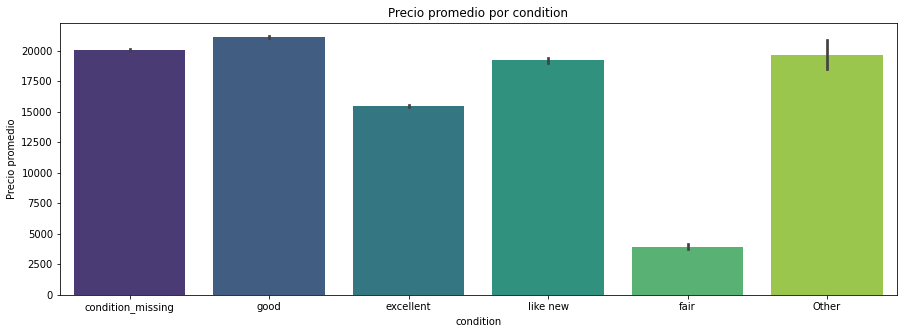

In [64]:
order = df['condition'].value_counts().index  

plt.figure(figsize=(15,5))
sns.barplot(data=df, x="condition", y="price", order=order, palette="viridis")

plt.title("Precio promedio por condition")
plt.xlabel("condition")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra el precio promedio de los autos según su condición. Llama la atención que la categoría “good” tiene uno de los precios más altos, incluso por encima de “excellent” y “like new”. Esto podría deberse a diferencias en cómo se clasifican las condiciones o a tamaños desiguales entre grupos. La categoría “fair” presenta el precio más bajo, lo cual es coherente con su peor estado. También destaca “condition_missing” y “Other” con valores altos, posiblemente por incluir datos atípicos o mal clasificados. En general, se confirma que el estado del vehículo tiene un impacto importante en su valor.


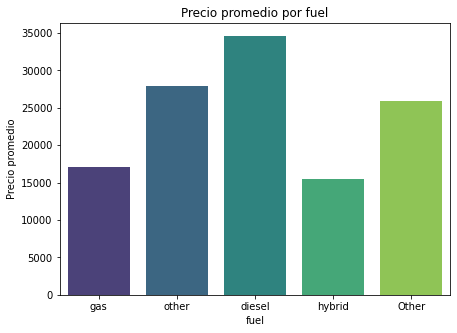

In [66]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="fuel", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por fuel")
plt.xlabel("fuel")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra el precio promedio de los autos según el tipo de combustible. Se observa que los vehículos a diésel tienen el precio promedio más alto, lo cual puede estar relacionado con que suelen ser modelos más grandes o comerciales. En contraste, los autos híbridos presentan el precio más bajo, lo que resulta curioso, ya que normalmente se espera que tengan un mayor valor por su tecnología. Los autos a gasolina, aunque comunes, tienen precios más bajos que la mayoría, lo que puede deberse a su amplia oferta en el mercado. La categoría “Other” también muestra precios elevados, probablemente por incluir tecnologías o combustibles alternativos.

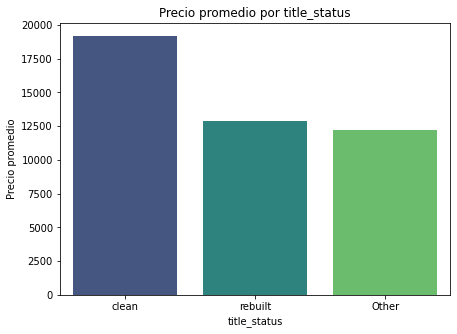

In [67]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="title_status", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por title_status")
plt.xlabel("title_status")
plt.ylabel("Precio promedio")

plt.show()

El gráfico evidencia que el estado del título del vehículo tiene un impacto directo en su precio promedio. Los autos con título "clean" alcanzan el valor más alto, cercano a los $19,000, lo que refleja mayor confianza del mercado en su historial legal y mecánico. En cambio, los vehículos con título "rebuilt" o clasificados como "Other" presentan precios significativamente más bajos (alrededor de $13,000), lo que sugiere que han pasado por reparaciones mayores o procesos de reconstrucción que afectan su valor percibido.

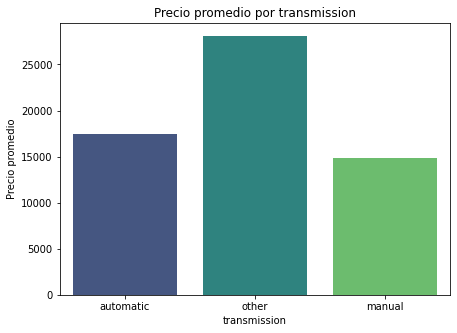

In [69]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="transmission", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por transmission")
plt.xlabel("transmission")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra que el tipo de transmisión influye directamente en el precio promedio de los vehículos. Los autos con transmisión "manual" tienen el valor más bajo, lo que puede asociarse a modelos más antiguos o económicos. En contraste, la categoría "other" presenta el precio más alto, lo que sugiere que agrupa transmisiones especializadas o poco comunes, posiblemente en vehículos de gama alta. La transmisión "automatic" se ubica en un rango intermedio, reflejando su popularidad y amplia presencia en el mercado. Esta distribución sugiere que la transmisión no solo afecta la experiencia de conducción, sino también el valor del vehículo.

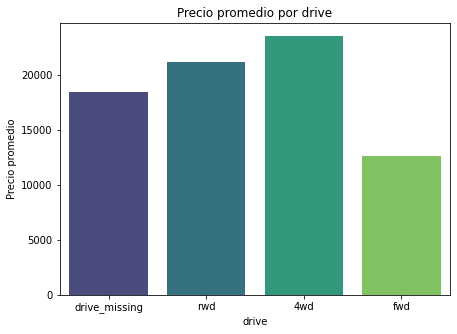

In [71]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x="drive", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por drive")
plt.xlabel("drive")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra el precio promedio de los autos según su tipo de tracción. Se observa que los vehículos con tracción en las cuatro ruedas (4wd) tienen el precio promedio más alto, lo que puede estar relacionado con su mayor capacidad para terrenos difíciles y su uso en vehículos todoterreno o de lujo. Los autos con tracción trasera (rwd) también presentan precios altos, mientras que los de tracción delantera (fwd) tienen el precio promedio más bajo, probablemente porque son más comunes y económicos. Los valores faltantes ("drive_missing") muestran un precio intermedio, lo que indica que puede haber datos incompletos o vehículos con características variadas en esa categoría.

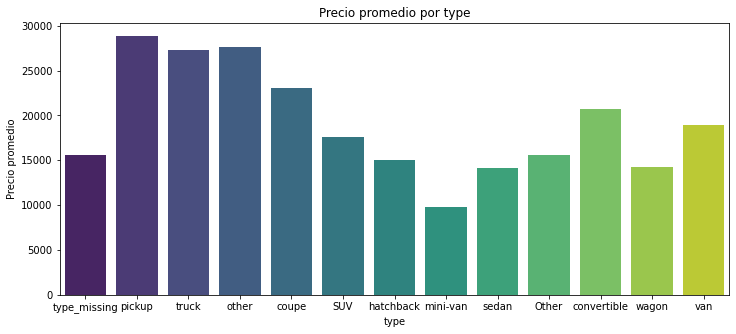

In [73]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x="type", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por type")
plt.xlabel("type")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra el precio promedio de los vehículos según su tipo. Se observa que los pickups y camiones (truck) tienen los precios promedio más altos, lo que puede estar relacionado con su tamaño, capacidad y demanda en ciertos mercados. Los convertibles también tienen un precio relativamente alto, posiblemente por su carácter deportivo o de lujo. Por otro lado, los autos con tipo "mini-van" y "hatchback" presentan los precios promedio más bajos, lo que sugiere que son opciones más económicas o familiares. La categoría "type_missing" muestra un precio bajo, lo que podría indicar datos faltantes o vehículos menos valorados.

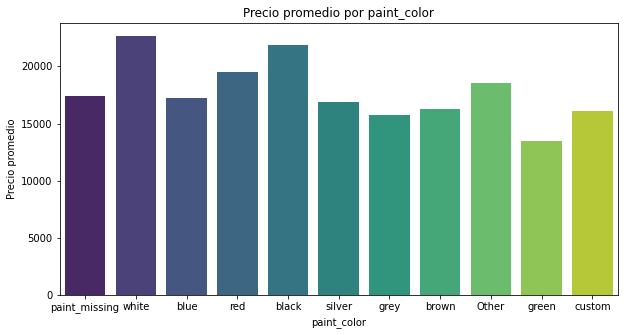

In [75]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="paint_color", y="price", estimator=np.mean, ci=None, palette="viridis")

plt.title("Precio promedio por paint_color")
plt.xlabel("paint_color")
plt.ylabel("Precio promedio")

plt.show()

El gráfico evidencia que el precio promedio de los vehículos varía según el color de pintura. Se observa que los autos de color blanco, negro y rojo presentan los valores más altos, lo que podría estar relacionado con su popularidad o asociación con segmentos de mayor valor. Por otro lado, los vehículos de color azul, plateado, gris, marrón y aquellos con pintura personalizada mantienen precios moderados. Finalmente, los autos de color verde registran los precios más bajos en comparación con el resto, lo que sugiere una menor demanda o una percepción de menor valor comercial en el mercado.

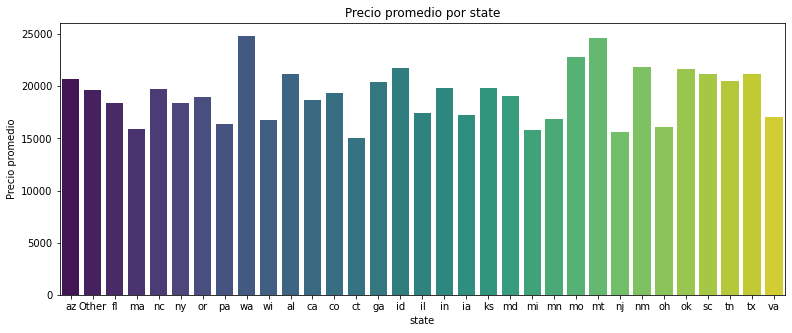

In [76]:
plt.figure(figsize=(13,5))
sns.barplot(data=df, x="state", y="price", estimator=np.mean, ci=None, palette="viridis")

# Personalización
plt.title("Precio promedio por state")
plt.xlabel("state")
plt.ylabel("Precio promedio")

plt.show()

El gráfico muestra una variación en el valor promedio de los vehículos según el estado de EE. UU. Representado mediante barras codificadas por color, se evidencia que ciertos estados alcanzan precios significativamente más altos, mientras que otros se mantienen en rangos más moderados. Esta disparidad puede estar vinculada a factores como el poder adquisitivo regional, la demanda del mercado automotriz local o las condiciones económicas particulares de cada estado.

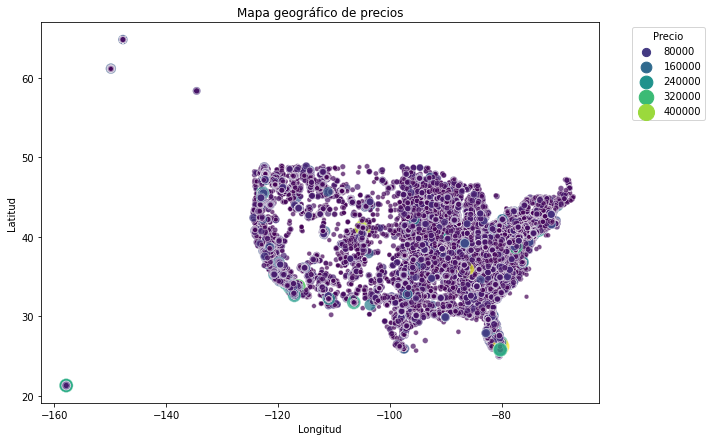

In [77]:
plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df,
    x="long",
    y="lat",
    hue="price",              # Color depende del precio
    size="price",             # Tamaño depende del precio
    sizes=(20, 300),          # Rango de tamaños
    palette="viridis",        # Colores tipo térmico
    alpha=0.7,                # Transparencia
    legend="brief"            # Mostrar leyenda
)

plt.title("Mapa geográfico de precios")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title="Precio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


El mapa revela una marcada concentración de valores elevados en zonas específicas de Estados Unidos, especialmente en áreas urbanas densamente pobladas. Los círculos más grandes y oscuros, que representan precios más altos, se agrupan en regiones como la costa oeste, el noreste y ciertos puntos del sur, lo que sugiere una correlación entre ubicación geográfica y poder adquisitivo o demanda del mercado. En contraste, las zonas con círculos más pequeños y claros indican precios más bajos, predominando en áreas rurales o menos densamente habitadas.

## ***5. Actualización de la base de datos***

In [78]:
df.to_csv("MP3_MODELOS.csv",index=False, encoding="utf-8")